# Extract aperiodic component of Sleep Data 

This script loads the pre-processed polysomnography data and extracts the apeiodic component of the EEG signal using the fooof algorithm (https://github.com/fooof-tools/fooof) and the IRASA algorithm (https://doi.org/10.1007/s10548-015-0448-0). The aperiodic component is then saved as a .csv file along with other spectrally derived information and specifically utilized parameters. 

In [2]:
%matplotlib inline

## Import packages 
import yasa
from fooof import FOOOF, FOOOFGroup
import numpy as np
import os
import mne
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal 
mne.set_log_level('WARNING')

In [3]:
## Adjusted YASA functions for computing aperiodic power spectrum based on IRASA method

def irasa(data, sf=None, ch_names=None, band=(1, 45),
          hset=[1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,
                1.55,1.6,1.65,1.7,1.75,1.8,1.85,1.9],
          return_fit=True,
          win_sec=4,
          kwargs_welch=dict(average="median", window="hamming"),
          verbose=True,
          ):
    """
    Separate the aperiodic (= fractal, or 1/f) and oscillatory component
    of the power spectra of EEG data using the IRASA method.

    .. versionadded:: 0.1.7

    Parameters
    ----------
    data : :py:class:`numpy.ndarray` or :py:class:`mne.io.BaseRaw`
        1D or 2D EEG data. Can also be a :py:class:`mne.io.BaseRaw`, in which
        case ``data``, ``sf``, and ``ch_names`` will be automatically
        extracted, and ``data`` will also be converted from Volts (MNE default)
        to micro-Volts (YASA).
    sf : float
        The sampling frequency of data AND the hypnogram.
        Can be omitted if ``data`` is a :py:class:`mne.io.BaseRaw`.
    ch_names : list
        List of channel names, e.g. ['Cz', 'F3', 'F4', ...]. If None,
        channels will be labelled ['CHAN000', 'CHAN001', ...].
        Can be omitted if ``data`` is a :py:class:`mne.io.BaseRaw`.
    band : tuple or None
        Broad band frequency range.
        Default is 1 to 30 Hz.
    hset : list or :py:class:`numpy.ndarray`
        Resampling factors used in IRASA calculation. Default is to use a range
        of values from 1.1 to 1.9 with an increment of 0.05.
    return_fit : boolean
        If True (default), fit an exponential function to the aperiodic PSD
        and return the fit parameters (intercept, slope) and :math:`R^2` of
        the fit.

        The aperiodic signal, :math:`L`, is modeled using an exponential
        function in semilog-power space (linear frequencies and log PSD) as:

        .. math:: L = a + \text{log}(F^b)

        where :math:`a` is the intercept, :math:`b` is the slope, and
        :math:`F` the vector of input frequencies.
    win_sec : int or float
        The length of the sliding window, in seconds, used for the Welch PSD
        calculation. Ideally, this should be at least two times the inverse of
        the lower frequency of interest (e.g. for a lower frequency of interest
        of 0.5 Hz, the window length should be at least 2 * 1 / 0.5 =
        4 seconds).
    kwargs_welch : dict
        Optional keywords arguments that are passed to the
        :py:func:`scipy.signal.welch` function.
    verbose : bool or str
        Verbose level. Default (False) will only print warning and error
        messages. The logging levels are 'debug', 'info', 'warning', 'error',
        and 'critical'. For most users the choice is between 'info'
        (or ``verbose=True``) and warning (``verbose=False``).

    Returns
    -------
    freqs : :py:class:`numpy.ndarray`
        Frequency vector.
    psd_aperiodic : :py:class:`numpy.ndarray`
        The fractal (= aperiodic) component of the PSD.
    psd_oscillatory : :py:class:`numpy.ndarray`
        The oscillatory (= periodic) component of the PSD.
    fit_params : :py:class:`pandas.DataFrame` (optional)
        Dataframe of fit parameters. Only if ``return_fit=True``.

    Notes
    -----
    The Irregular-Resampling Auto-Spectral Analysis (IRASA) method is
    described in Wen & Liu (2016). In a nutshell, the goal is to separate the
    fractal and oscillatory components in the power spectrum of EEG signals.

    The steps are:

    1. Compute the original power spectral density (PSD) using Welch's method.
    2. Resample the EEG data by multiple non-integer factors and their
       reciprocals (:math:`h` and :math:`1/h`).
    3. For every pair of resampled signals, calculate the PSD and take the
       geometric mean of both. In the resulting PSD, the power associated with
       the oscillatory component is redistributed away from its original
       (fundamental and harmonic) frequencies by a frequency offset that varies
       with the resampling factor, whereas the power solely attributed to the
       fractal component remains the same power-law statistical distribution
       independent of the resampling factor.
    4. It follows that taking the median of the PSD of the variously
       resampled signals can extract the power spectrum of the fractal
       component, and the difference between the original power spectrum and
       the extracted fractal spectrum offers an approximate estimate of the
       power spectrum of the oscillatory component.

    Note that an estimate of the original PSD can be calculated by simply
    adding ``psd = psd_aperiodic + psd_oscillatory``.

    For an example of how to use this function, please refer to
    https://github.com/raphaelvallat/yasa/blob/master/notebooks/09_IRASA.ipynb

    For an article discussing the challenges of using IRASA (or fooof) see [5].

    References
    ----------
    [1] Wen, H., & Liu, Z. (2016). Separating Fractal and Oscillatory
        Components in the Power Spectrum of Neurophysiological Signal.
        Brain Topography, 29(1), 13–26.
        https://doi.org/10.1007/s10548-015-0448-0

    [2] https://github.com/fieldtrip/fieldtrip/blob/master/specest/

    [3] https://github.com/fooof-tools/fooof

    [4] https://www.biorxiv.org/content/10.1101/299859v1

    [5] https://doi.org/10.1101/2021.10.15.464483
    """
    import fractions
    from yasa.io import set_log_level
    import logging

    set_log_level(verbose)
    # Check if input data is a MNE Raw object
    if isinstance(data, mne.io.BaseRaw):
        sf = data.info["sfreq"]  # Extract sampling frequency
        ch_names = data.ch_names  # Extract channel names
        hp = data.info["highpass"]  # Extract highpass filter
        lp = data.info["lowpass"]  # Extract lowpass filter
        data = data.get_data(units=dict(eeg="uV", emg="uV", eog="uV", ecg="uV"))
    else:
        # Safety checks
        assert isinstance(data, np.ndarray), "Data must be a numpy array."
        data = np.atleast_2d(data)
        assert data.ndim == 2, "Data must be of shape (nchan, n_samples)."
        nchan, npts = data.shape
        assert nchan < npts, "Data must be of shape (nchan, n_samples)."
        assert sf is not None, "sf must be specified if passing a numpy array."
        assert isinstance(sf, (int, float))
        if ch_names is None:
            ch_names = ["CHAN" + str(i).zfill(3) for i in range(nchan)]
        else:
            ch_names = np.atleast_1d(np.asarray(ch_names, dtype=str))
            assert ch_names.ndim == 1, "ch_names must be 1D."
            assert len(ch_names) == nchan, "ch_names must match data.shape[0]."
        hp = 0  # Highpass filter unknown -> set to 0 Hz
        lp = sf / 2  # Lowpass filter unknown -> set to Nyquist

    # Check the other arguments
    hset = np.asarray(hset)
    assert hset.ndim == 1, "hset must be 1D."
    assert hset.size > 1, "2 or more resampling fators are required."
    hset = np.round(hset, 4)  # avoid float precision error with np.arange.
    band = sorted(band)
    assert band[0] > 0, "first element of band must be > 0."
    assert band[1] < (sf / 2), "second element of band must be < (sf / 2)."
    win = int(win_sec * sf)  # nperseg

    # Inform about maximum resampled fitting range
    h_max = np.max(hset)
    band_evaluated = (band[0] / h_max, band[1] * h_max)
    freq_Nyq = sf / 2  # Nyquist frequency
    freq_Nyq_res = freq_Nyq / h_max  # minimum resampled Nyquist frequency
    logging.info(f"Fitting range: {band[0]:.2f}Hz-{band[1]:.2f}Hz")
    logging.info(f"Evaluated frequency range: {band_evaluated[0]:.2f}Hz-{band_evaluated[1]:.2f}Hz")
    if band_evaluated[0] < hp:
        logging.warning(
            "The evaluated frequency range starts below the "
            f"highpass filter ({hp:.2f}Hz). Increase the lower band"
            f" ({band[0]:.2f}Hz) or decrease the maximum value of "
            f"the hset ({h_max:.2f})."
        )
    if band_evaluated[1] > lp and lp < freq_Nyq_res:
        logging.warning(
            "The evaluated frequency range ends after the "
            f"lowpass filter ({lp:.2f}Hz). Decrease the upper band"
            f" ({band[1]:.2f}Hz) or decrease the maximum value of "
            f"the hset ({h_max:.2f})."
        )
    if band_evaluated[1] > freq_Nyq_res:
        logging.warning(
            "The evaluated frequency range ends after the "
            "resampled Nyquist frequency "
            f"({freq_Nyq_res:.2f}Hz). Decrease the upper band "
            f"({band[1]:.2f}Hz) or decrease the maximum value "
            f"of the hset ({h_max:.2f})."
        )

    # Calculate the original PSD over the whole data
    freqs, psd = signal.welch(data, sf, nperseg=win, **kwargs_welch)

    # Start the IRASA procedure
    psds = np.zeros((len(hset), *psd.shape))

    for i, h in enumerate(hset):
        # Get the upsampling/downsampling (h, 1/h) factors as integer
        rat = fractions.Fraction(str(h))
        up, down = rat.numerator, rat.denominator
        # Much faster than FFT-based resampling
        data_up = signal.resample_poly(data, up, down, axis=-1)
        data_down = signal.resample_poly(data, down, up, axis=-1)
        # Calculate the PSD using same params as original
        freqs_up, psd_up = signal.welch(data_up, h * sf, nperseg=win, **kwargs_welch)
        freqs_dw, psd_dw = signal.welch(data_down, sf / h, nperseg=win, **kwargs_welch)
        # Geometric mean of h and 1/h
        psds[i, :] = np.sqrt(psd_up * psd_dw)

    # Now we take the median PSD of all the resampling factors, which gives
    # a good estimate of the aperiodic component of the PSD.
    psd_aperiodic = np.median(psds, axis=0)

    # We can now calculate the oscillations (= periodic) component.
    psd_osc = psd - psd_aperiodic

    # Let's crop to the frequencies defined in band
    mask_freqs = np.ma.masked_outside(freqs, *band).mask
    freqs = freqs[~mask_freqs]
    psd_aperiodic = np.compress(~mask_freqs, psd_aperiodic, axis=-1)
    psd_osc = np.compress(~mask_freqs, psd_osc, axis=-1)

    if return_fit:
        # Aperiodic fit in semilog space for each channel
        from scipy.optimize import curve_fit

        intercepts, slopes, r_squared = [], [], []

        def func(t, a, b):
            # See https://github.com/fooof-tools/fooof
            return a + np.log10(t**b)

        for y in np.atleast_2d(psd_aperiodic):
            y_log = np.log10(y)
            # Note that here we define bounds for the slope but not for the
            # intercept.
            popt, pcov = curve_fit(
                func, freqs, y_log, p0=(2, -1), bounds=((-np.inf, -10), (np.inf, 2))
            )
            intercepts.append(popt[0])
            slopes.append(popt[1])
            # Calculate R^2: https://stackoverflow.com/q/19189362/10581531
            residuals = y_log - func(freqs, *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((y_log - np.mean(y_log)) ** 2)
            r_squared.append(1 - (ss_res / ss_tot))

        # Create fit parameters dataframe
        fit_params = {
            "Chan": ch_names,
            "Intercept": intercepts,
            "Slope": slopes,
            "R^2": r_squared,
            "std(osc)": np.std(psd_osc, axis=-1, ddof=1),
        }
        return freqs, psd_aperiodic, psd_osc, pd.DataFrame(fit_params)
    else:
        return freqs, psd_aperiodic, psd_osc

def compute_irasa_power(data, hypnogram, sf, subject, band=(1, 45), h_set_max=1.5):
    """
    Compute the IRASA power spectrum for each sleep stage.

    Parameters:
    -----------
    data : ndarray
        2D EEG data where columns represent time points and rows represent different channels.
    hypnogram : ndarray
        1D array representing the sleep stage for each time point in data.
    sf : float
        Sampling frequency of the EEG data.
    subject : str
        Identifier for the subject whose data is being processed.
    band : tuple
        Frequency band to compute the IRASA power spectrum over.

    Returns:
    --------
    fit_df : DataFrame
        A DataFrame containing fit parameters for each sleep stage.
    psd_df : DataFrame
        A DataFrame containing power spectral density values for each sleep stage.

    Notes:
    ------
    This function uses the YASA library's IRASA method to separate oscillatory and aperiodic components 
    of the EEG power spectrum for each sleep stage. It then computes bandpower for each component and optionally
    plots the PSD for each component.
    """

    fit_dfs = []
    psd_dfs = []
    psd_freq_dfs = [] 
    
    for stage in np.unique(hypnogram):
        if stage >= 0:
            stage_data = data[:, hypnogram == int(stage)]

            # Extract aperiodic and oscillatory components of the PSD
            freqs, psd_aperiodic, psd_oscillatory, fit_params = irasa( # type: ignore
                stage_data, sf=sf, ch_names=['C3', 'C4'], band=band,
                return_fit=True, win_sec=2,
                hset=np.arange(1.0, h_set_max + 0.05, 0.05),
                kwargs_welch=dict(average='median', window='hamming')
            )
            fit_params['Stage'] = stage
            fit_params['Subject'] = subject
            fit_dfs.append(fit_params)

            psd_df_stage = []
            psd_freq_df_stage = []
            for psd_obj, psd_name in zip([psd_aperiodic, psd_oscillatory, (psd_aperiodic + psd_oscillatory)], 
                                         ['Aperiodic', 'Oscillatory', 'Total']):
                
                # Extract the values at specific frequencies
                tmp_df = pd.DataFrame(psd_obj.T, index=freqs, columns=['C3', 'C4'])
                tmp_df = tmp_df.reset_index().melt(id_vars=['index'], value_vars=['C3', 'C4'], 
                                                   var_name='Channel', value_name='Power Value')
                
                tmp_df['Power'] = psd_name
                tmp_df['Stage'] = stage
                tmp_df['Subject'] = subject
                tmp_df.rename(columns={'index': 'Frequency'}, inplace=True)
                psd_freq_df_stage.append(tmp_df)

                # Compute relative bandpower from PSD objects
                psd_ = yasa.bandpower_from_psd(
                    psd=psd_obj, freqs=freqs, ch_names=['C3', 'C4'],
                    bands=[(0.5, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
                        (12, 16, 'Sigma'), (16, 30, 'Beta'), (30, 40, 'Gamma')],
                    relative=True
                )
                psd_['Power'] = psd_name
                psd_['Stage'] = stage
                psd_['Subject'] = subject
                psd_df_stage.append(pd.DataFrame(psd_))
    
            psd_dfs.append(pd.concat(psd_df_stage, axis=0))
            psd_freq_dfs.append(pd.concat(psd_freq_df_stage, axis=0))

    fit_df = pd.concat(fit_dfs, axis=0)
    psd_df = pd.concat(psd_dfs, axis=0)
    psd_freq_df = pd.concat(psd_freq_dfs, axis=0)

    return fit_df.reset_index(drop=True), psd_df.reset_index(drop=True), psd_freq_df.reset_index(drop=True)

def plot_spectral_components(freqs, psd, save=True, fig_path=None):
    # Plot the given component on a linear-log scale
    plt.plot(freqs, psd.mean(0), 'k', lw=2)
    plt.xlim(0.5, 30)
    plt.yscale('log')
    sns.despine()
    plt.title(f'Spectral components - EEG Avg. (C3, C4)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD log($uV^2$/Hz)');

    if save:
        plt.savefig(f'{fig_path}.png')
        plt.close('all')


In [4]:
# Compute the aperiodic exponent via: https://github.com/Mark-Kramer/Aperiodic-Exponent-Model/blob/main/one_over_f_functions.py

# Compute the spectrum.
def compute_spectrum(x,t):                         # Compute the spectrum of signal x, time axis t in [s].
    N   = np.size(x)                               # Number of data points
    dt  = t[2]-t[1]                                # Time resolution, in [s].
    T   = t[-1]                                    # Total time of data, in [s].
    xf  = np.fft.fft(np.hanning(N)*(x-np.mean(x))) # Fourier transform of data, Hanning taper, 0-mean.
    S   = np.real(2*dt**2/T*(xf*np.conj(xf)))      # Spectrum
    S   = S[1:int(N/2)+1]                          # Keep only non-negative frequencies
    df  = 1/T                                      # Frequency resolution, in [Hz]
    fNQ = 1/dt/2                                   # Nyquist frequency, in [Hz]
    f   = np.arange(0,fNQ,df)                      # Frequency axis, in [Hz]
    return S, f

# Compute the aperiodic exponent.
def estimate_aperiodic_exponent(S,f,finterval):
    freq_interval_to_fit = (f >= finterval[0]) & (f<=finterval[1])      # For this frequency range,
                                                                        # Fit linear model: log10(S) vs log10(f)
    linear_fit           = np.polyfit(np.log10(f[freq_interval_to_fit]), np.log10(S[freq_interval_to_fit]), 1)
    x_linear_fit         = np.log10(f[freq_interval_to_fit])            # Return x-axis of fit.
    y_linear_fit         = linear_fit[1] + linear_fit[0]*x_linear_fit   # Return y-axis of fit.
    aperiodic_exponent   = linear_fit[0]                                # Return aperiodic exponent.

    return aperiodic_exponent, x_linear_fit, y_linear_fit

# Plot trace and spectrum with fit.
def make_plots(t,x, f,S, x_linear_fit,y_linear_fit,aperiodic_exponent, axX,axS):
    axX.plot(t,x, 'k');                              axX.set(xlabel="Time [s]", ylabel='[a.u.]')
    axS.plot(np.log10(f[2:]), np.log10(S[2:]), 'k'); axS.set(xlabel="Log$_{10}$(Frequency [Hz]", ylabel="Log$_{10}$(P)")
    axS.plot(x_linear_fit, y_linear_fit, 'r');       axS.text(x_linear_fit[0],y_linear_fit[0]+2, "Aperiodic exponent: %.2f" % aperiodic_exponent);
    axX.spines["top"].set_visible(False); axX.spines["right"].set_visible(False)
    axS.spines["top"].set_visible(False); axS.spines["right"].set_visible(False) 

In [5]:
## Function to compute the aperiodic exponent with FOOOF for each sleep stage for channel C3 and C4

def compute_fooof_aperiodic_exponent(data, sf, hypnogram, subject, band=(1, 45)):
    # Initialize FOOOF object
    fg = FOOOF(max_n_peaks=1, aperiodic_mode='fixed', verbose=False)
    aperiodic_exponent_dfs = []
    # Compute the power spectrum for each sleep stage
    for stage in np.unique(hypnogram):
        if stage >= 0:
            # Slice the data based on sleep stage
            stage_data = data[:, hypnogram == stage]
            # Slice the data based on channel
            for idx, ch_name in enumerate(['C3', 'C4']):
                # Compute the power spectrum
                freqs, psd = signal.welch(stage_data[idx, :], sf, nperseg=int(2*sf), 
                                          average='median', window='hamming')
                freqs_foi = freqs[(freqs >= band[0]) & (freqs <= band[1])]
                psd_foi = psd[(freqs >= band[0]) & (freqs <= band[1])]
                # Fit the FOOOF model
                fg.fit(freqs, psd, freq_range=band)
                # Extract the aperiodic exponent
                aperiodic_exponent = fg.get_params('aperiodic_params', 'exponent')
                r2s = fg.get_params('r_squared')
                intercept = fg.get_params('aperiodic_params', 'offset')
                # Store the aperiodic exponent
                aperiodic_exponent_df = pd.DataFrame({
                    'Subject': [subject]*len(freqs_foi),
                    'Stage': [stage]*len(freqs_foi),
                    'Chan': [ch_name]*len(freqs_foi),
                    'Slope': [aperiodic_exponent]*len(freqs_foi),
                    'R^2': [r2s]*len(freqs_foi), 
                    'Intercept': [intercept]*len(freqs_foi),
                    'std(osc)': [np.std(psd_foi, axis=-1, ddof=1)]*len(freqs_foi),
                    'Spectrum': psd_foi,
                    'Frequency': freqs_foi
                })
                aperiodic_exponent_dfs.append(aperiodic_exponent_df)

    # Combine all dataframes
    aperiodic_exponent_df_all = pd.concat(aperiodic_exponent_dfs, axis=0)

    return aperiodic_exponent_df_all.reset_index(drop=True)

## 1. Load data

In [6]:
# Set paths
path = '/mnt/server/data03/2023_NENA_Aperiodic_Workshop/data/processed/'
fig_path = '/mnt/server/data03/2023_NENA_Aperiodic_Workshop/figures/subject/'
# Obtain list of unique recordings
files = list(set(["-".join(f.split('-')[0:3]) for f in os.listdir(path)]))

## 2. Process and extract aperiodic component from recording files

In [7]:
## Iterate over all files and process them
fit_dfs, psd_dfs, fooof_dfs, psd_freq_dfs = [], [], [], []
for idx, file in enumerate(tqdm(files)):
    print(f'Detecting and labeling artifacts in file : {file}')
    # Load the data and hypnogram files
    subject = file.split('-')[-1]
    raw = mne.io.read_raw_fif(path + file + '-raw.fif.gz', preload=True)
    hypnogram = np.load(path + file + '-hypnogram_with_art.npy')
    # Get sampling frequency
    sf = raw.info['sfreq']
    # Get data
    data = raw.get_data(['C3','C4'], units='uV') 
    # Extract aperiodic component with IRASA from yasa per sleep stage
    fit_df, psd_df, psd_freq_df = compute_irasa_power(data, hypnogram, sf, subject, band=(1, 45), h_set_max=1.5)
    fit_df['Method'] = 'IRASA'
    psd_df['Method'] = 'IRASA'
    psd_freq_df['Method'] = 'IRASA'
    fit_dfs.append(fit_df)
    psd_dfs.append(psd_df)
    psd_freq_dfs.append(psd_freq_df)
    # Extract aperiodic component with FOOOF per sleep stage
    fooof_df = compute_fooof_aperiodic_exponent(data, sf, hypnogram, subject, band=(1, 45))
    fooof_df['Method'] = 'FOOOF'   
    fooof_dfs.append(fooof_df)

# Combine all dataframes
fit_df_all = pd.concat(fit_dfs, axis=0)
psd_df_all = pd.concat(psd_dfs, axis=0)
psd_freq_df_all = pd.concat(psd_freq_dfs, axis=0)
fooof_df_all = pd.concat(fooof_dfs, axis=0)

  0%|          | 0/50 [00:00<?, ?it/s]

Detecting and labeling artifacts in file : cfs-visit5-800347


31-Aug-23 21:52:18 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:52:18 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:52:28 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:52:34 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-802487


31-Aug-23 21:53:39 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:53:40 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:53:47 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:53:52 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801747


31-Aug-23 21:54:49 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:54:49 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:55:01 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:55:04 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-802491


31-Aug-23 21:56:17 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:56:17 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:56:23 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:56:28 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800407


31-Aug-23 21:57:28 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:57:29 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:57:38 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:57:42 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801602


31-Aug-23 21:58:42 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:58:43 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:58:54 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:58:57 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-802643


31-Aug-23 21:59:58 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 21:59:59 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:00:11 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:00:15 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801540


31-Aug-23 22:01:22 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:01:23 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:01:29 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:01:32 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801291


31-Aug-23 22:02:41 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:02:41 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:02:50 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:02:54 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801323


31-Aug-23 22:03:47 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:03:48 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:03:57 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:04:00 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800667


31-Aug-23 22:05:01 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:05:01 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:05:09 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:05:12 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800184


31-Aug-23 22:06:12 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:06:12 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:06:21 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:06:23 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800092


31-Aug-23 22:07:23 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:07:23 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:07:35 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:07:39 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801152


31-Aug-23 22:08:40 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:08:40 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:08:45 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:08:53 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801497


31-Aug-23 22:09:53 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:09:53 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:09:58 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:10:04 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800494


31-Aug-23 22:11:15 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:11:15 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:11:18 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:11:22 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-802298


31-Aug-23 22:12:25 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:12:25 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:12:36 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:12:40 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800249


31-Aug-23 22:13:42 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:13:43 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:13:48 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:13:53 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801907


31-Aug-23 22:14:55 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:14:55 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:15:03 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:15:07 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801225


31-Aug-23 22:16:09 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:16:09 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:16:20 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:16:24 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800243


31-Aug-23 22:17:27 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:17:27 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:17:38 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:17:42 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-802709


31-Aug-23 22:18:51 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:18:51 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:18:57 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:19:00 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801393


31-Aug-23 22:20:03 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:20:04 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:20:12 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:20:15 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800331


31-Aug-23 22:21:05 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:21:05 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:21:13 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:21:17 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800630


31-Aug-23 22:22:24 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:22:25 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:22:34 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:22:36 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-802739


31-Aug-23 22:23:41 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:23:41 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:23:48 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:23:50 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801019


31-Aug-23 22:24:54 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:24:54 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:25:04 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:25:06 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801638


31-Aug-23 22:26:08 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:26:09 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:26:16 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:26:22 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801044


31-Aug-23 22:27:21 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:27:22 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:27:29 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:27:31 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801058


31-Aug-23 22:28:33 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:28:34 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:28:42 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:28:45 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801196


31-Aug-23 22:29:49 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:29:50 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:29:59 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:30:01 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-802380


31-Aug-23 22:31:03 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:31:04 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:31:11 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:31:15 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801825


31-Aug-23 22:32:15 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:32:16 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:32:23 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:32:27 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-802132


31-Aug-23 22:33:23 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:33:23 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:33:32 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:33:35 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800551


31-Aug-23 22:34:40 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:34:40 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:34:48 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:34:51 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-802073


31-Aug-23 22:35:57 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:35:58 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:36:05 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:36:08 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801662


31-Aug-23 22:37:01 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:37:01 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:37:09 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:37:11 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800625


31-Aug-23 22:38:07 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:38:07 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:38:11 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:38:20 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800861


31-Aug-23 22:39:13 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:39:13 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:39:19 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:39:24 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-802635


31-Aug-23 22:40:23 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:40:23 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:40:31 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:40:35 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800705


31-Aug-23 22:41:39 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:41:39 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:41:46 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:41:50 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800212


31-Aug-23 22:42:52 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:42:53 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:43:01 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:43:04 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800010


31-Aug-23 22:44:16 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:44:16 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:44:23 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:44:25 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-802177


31-Aug-23 22:45:26 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:45:26 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:45:34 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:45:38 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-802125


31-Aug-23 22:46:41 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:46:41 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:46:51 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:46:53 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-800151


31-Aug-23 22:47:54 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:47:55 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:48:01 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:48:05 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801001


31-Aug-23 22:49:03 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:49:17 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
 94%|█████████▍| 47/50 [57:50<03:37, 72.51s/it]

Detecting and labeling artifacts in file : cfs-visit5-800535


31-Aug-23 22:50:21 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:50:22 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:50:27 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:50:32 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-802691


31-Aug-23 22:51:35 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:51:35 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:51:44 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:51:46 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


Detecting and labeling artifacts in file : cfs-visit5-801380


31-Aug-23 22:52:49 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:52:50 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:52:56 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29
31-Aug-23 22:52:59 | WARNING | There are negative values in PSD. This will result in incorrect bandpower values. We highly recommend working with an all-positive PSD. For more details, please refer to: https://github.com/raphaelvallat/yasa/issues/29


In [28]:
# Merge fit_df_all and fooof_df_all on common columns
fit_dfs_all = pd.concat([fit_df_all, 
                         fooof_df_all.groupby(['Subject', 'Stage', 'Chan', 'Method']).mean().reset_index()], join='inner', axis=0)
fit_dfs_all['Slope'] = np.abs(fit_dfs_all['Slope'])
fit_dfs_all

,Chan,Intercept,Slope,R^2,std(osc),Stage,Subject,Method
0,C3,2.156118,1.922518,0.763763,1.135043,0.0,800347,IRASA
1,C4,2.142987,1.903973,0.754085,0.604734,0.0,800347,IRASA
2,C3,2.272878,2.237325,0.833050,0.208985,1.0,800347,IRASA
3,C4,2.338193,2.252922,0.826736,0.173760,1.0,800347,IRASA
4,C3,2.746657,2.678309,0.868836,0.339442,2.0,800347,IRASA
...,...,...,...,...,...,...,...,...
489,C4,1.898626,2.146008,0.996342,6.627506,2.0,802739,FOOOF
490,C3,2.556940,2.529882,0.989006,35.671939,3.0,802739,FOOOF
491,C4,2.502477,2.600785,0.993469,54.402790,3.0,802739,FOOOF
492,C3,1.521430,1.837515,0.986738,3.094053,4.0,802739,FOOOF


In [27]:
fit_dfs_all.to_csv('/mnt/server/data03/2023_NENA_Aperiodic_Workshop/data/processed/aperiodic.csv', index=False)

In [54]:
fit_dfs_all

,Chan,Intercept,Slope,R^2,std(osc),Stage,Subject,Method
0,C3,2.156118,1.922518,0.763763,1.135043,0.0,800347,IRASA
1,C4,2.142987,1.903973,0.754085,0.604734,0.0,800347,IRASA
2,C3,2.272878,2.237325,0.833050,0.208985,1.0,800347,IRASA
3,C4,2.338193,2.252922,0.826736,0.173760,1.0,800347,IRASA
4,C3,2.746657,2.678309,0.868836,0.339442,2.0,800347,IRASA
...,...,...,...,...,...,...,...,...
489,C4,1.898626,2.146008,0.996342,6.627506,2.0,802739,FOOOF
490,C3,2.556940,2.529882,0.989006,35.671939,3.0,802739,FOOOF
491,C4,2.502477,2.600785,0.993469,54.402790,3.0,802739,FOOOF
492,C3,1.521430,1.837515,0.986738,3.094053,4.0,802739,FOOOF


Text(0.5, 1.0, 'Aperiodic Exponent Distribution')

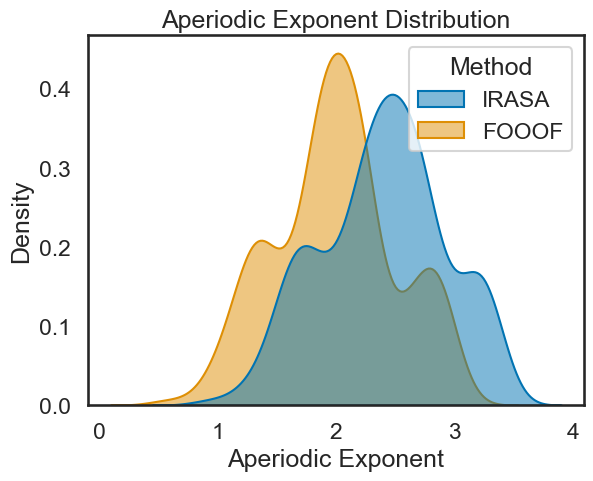

In [64]:
sns.kdeplot(data=fit_dfs_all, x='Slope', hue='Method', fill=True, alpha=0.5)
plt.xlabel('Aperiodic Exponent')
plt.ylabel('Density')
plt.title('Aperiodic Exponent Distribution')


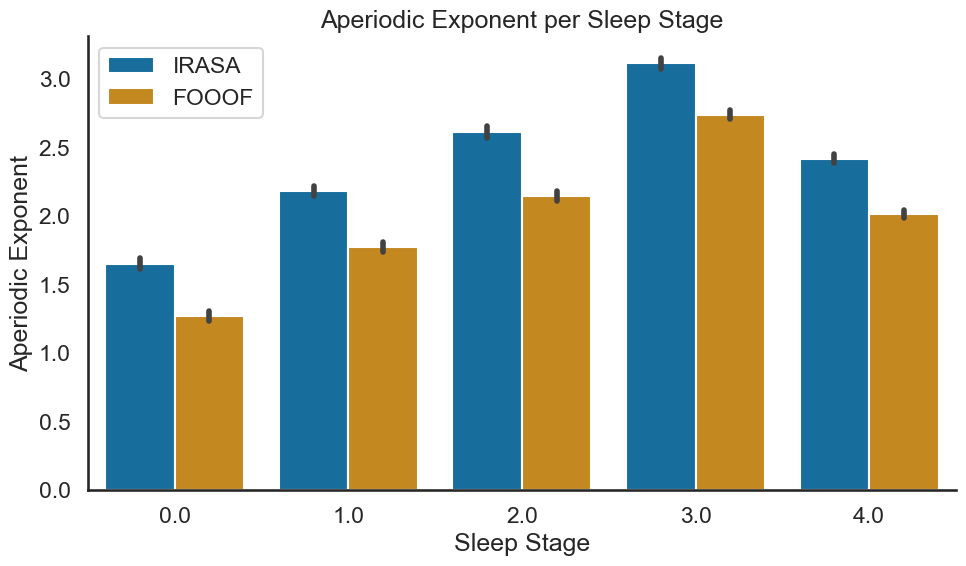

In [16]:
# Plot the aperiodic exponent for each sleep stage
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('colorblind')
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=fit_dfs_all, x='Stage', y='Slope', hue='Method', ax=ax)
ax.set_xlabel('Sleep Stage')
ax.set_ylabel('Aperiodic Exponent')
ax.set_title('Aperiodic Exponent per Sleep Stage')
ax.legend(loc='upper left')
sns.despine()
plt.tight_layout()

In [17]:
def foi_range_irasa(foi=(1,45), hset_max=1.9):
    """

    Calculate the frequency range to evaluate the IRASA power spectrum.

    Parameters
    ----------
    foi : tuple of int or float
        Frequency range of interest.
    hset_max : float
        Maximum resampling factor.

    """

    freq_eval_min = foi[0] / hset_max
    freq_eval_max = foi[1] * hset_max

    return freq_eval_min, freq_eval_max

freq_min, freq_max = foi_range_irasa(foi=(1,30), hset_max=1.5)
freq_min, freq_max

(0.6666666666666666, 45.0)

In [ ]:
filtered_df = psd_freq_df[(psd_freq_df['Channel'] == 'C3') & 
                          (psd_freq_df['Power'] == 'Aperiodic') & 
                          (psd_freq_df['Stage'] == 3)
                         ]

aperiodic_exponent, x_linear_fit, y_linear_fit = estimate_aperiodic_exponent(filtered_df['Power Value'].values, 
                                                                             filtered_df['Frequency'].values,
                                                                             finterval=(1, 45))
aperiodic_exponent